In [1]:
import os
import csv

import matplotlib.pyplot as plt

In [4]:
def find_last_frame_idx(directory):
    if not os.path.exists(directory):
        print('folder %s does not exist' % directory)
        return None
    highest_number = -float('inf')  # Start with a very low number
    for file_name in os.listdir(directory):
        try:
            # Extract the number from the file name
            number = int(file_name.split('.')[0])  # Assuming numbers are before the file extension
            if number > highest_number:
                highest_number = number
        except ValueError:
            # Skip files that don't have a number as their name
            continue
    return highest_number if highest_number != -float('inf') else None

def find_closest_frame_idx(directory, frame_number):
    if not os.path.exists(directory):
        print('folder %s does not exist' % directory)
        return None
    closest_number = None
    smallest_diff = float('inf')  # Start with a very low number
    for file_name in os.listdir(directory):
        try:
            # Extract the number from the file name
            number = int(file_name.split('.')[0])  # Assuming numbers are before the file extension
            diff = abs(number - frame_number)
            if diff < smallest_diff:
                smallest_diff = diff
                closest_number = number
        except ValueError:
            # Skip files that don't have a number as their name
            continue
    return closest_number

directory_path = "/data/Datasets/ag/frames/C93HZ.mp4"
highest = find_last_frame_idx(directory_path)
print(highest)

closest = find_closest_frame_idx(directory_path, 100)
print(closest)

713
102


In [5]:
def string_to_action_triple(action_string, video_id):
    a = action_string.split(' ')
    if len(a) == 3:
        action_triple = (video_id, int(a[0][1:]), float(a[1]), float(a[2]))
    elif len(a) == 1 and a[0] == '':
        return None
    else:
        print('invalid string')
        return None
    return action_triple

root = '/data/Datasets/ag/'
actions = []

with open(root + 'annotations/Charades/Charades_v1_train.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        video_id = row['id']
        action_string = row['actions'].split(';')
        for action in action_string:
            action_tuple = string_to_action_triple(action, video_id)
            if action_tuple:
                actions.append(action_tuple)



In [6]:
def get_frame_from_time(video_id, time, fps=24):
    frame_number = int(time * fps)
    directory = os.path.join(root, 'frames', video_id + '.mp4')
    return find_closest_frame_idx(directory, frame_number)


In [10]:
'''
gets all usable frame-action pairs, where the frame should be the very beginning of the action
threshold: the maximum deviation in seconds between the start time of the action and the frame time
'''
def extract_usable_frames(threshold, fps=24, plot=False):
    distribution = []
    data_list = []

    for video_id, action_class, start_time, end_time in actions:
        frame_idx = get_frame_from_time(video_id, start_time)
        if frame_idx:
            deviation = abs((frame_idx / fps) - start_time)
            if plot:
                distribution.append(deviation)
            if deviation < threshold:
                data_list.append((video_id, frame_idx, action_class))

    if plot:
        plt.hist(distribution, bins=100, range=(0, 5))
    
    return data_list

data_list = extract_usable_frames(1)
print(len(data_list))


folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/QQ9RN.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/RTULL.mp4 does not exist
folder /data/Datasets/ag/frames/VKLP7.mp4 does not exist
folder /data/Datasets/ag/frames

In [11]:
import pickle 

with open(root + 'annotations/person_bbox.pkl', 'rb') as f:
    person_bbox = pickle.load(f)
f.close()
with open(root+'annotations/object_bbox_and_relationship.pkl', 'rb') as f:
    object_bbox = pickle.load(f)
f.close()

In [16]:
len(object_bbox.keys())

288782

In [34]:

video_id = 'C93HZ'
frame_idx = 557 
id = "%s.mp4/%06d.png" % (video_id, frame_idx)
print(id)

print(os.path.exists(os.path.join(root, 'frames', id)))

#person_bbox[id]
object_bbox[id]

C93HZ.mp4/000557.png
True


[{'class': 'clothes',
  'bbox': None,
  'attention_relationship': None,
  'spatial_relationship': None,
  'contacting_relationship': None,
  'metadata': {'tag': 'C93HZ.mp4/clothes/000557', 'set': 'train'},
  'visible': False},
 {'class': 'chair',
  'bbox': (320.4147727272725, 126.69318181818153, 65.0, 142.8125),
  'attention_relationship': ['not_looking_at'],
  'spatial_relationship': ['beneath', 'behind'],
  'contacting_relationship': ['sitting_on'],
  'metadata': {'tag': 'C93HZ.mp4/chair/000557', 'set': 'train'},
  'visible': True},
 {'class': 'cup/glass/bottle',
  'bbox': (177.09309471588645,
   148.17903735019775,
   13.088340688078944,
   27.941612428352244),
  'attention_relationship': ['not_looking_at'],
  'spatial_relationship': ['in_front_of', 'on_the_side_of'],
  'contacting_relationship': ['not_contacting'],
  'metadata': {'tag': 'C93HZ.mp4/cup_glass_bottle/000557', 'set': 'train'},
  'visible': True}]

In [35]:
arr = [[1,2,3], [4,5,6], [7,8,9]]
for a,b,c in arr:
    print(a,b,c)

1 2 3
4 5 6
7 8 9


In [ ]:
from data.action_genome import AG

root = '/data/Datasets/ag/'
ag_dataset = AG(root)

folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/QQ9RN.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/RTULL.mp4 does not exist
folder /data/Datasets/ag/frames/VKLP7.mp4 does not exist
folder /data/Datasets/ag/frames

(<PIL.Image.Image image mode=RGB size=480x270>,
 Data(x=[1, 37], edge_index=[0], edge_attr=[0, 26], y=[1], node_type=[1], edge_type=[0], id='46GP8.mp4/000272.png'),
 92)

Data(x=[3, 37], edge_index=[2, 6], edge_attr=[6, 26], y=[1], node_type=[3], edge_type=[6], id='KRF68.mp4/000142.png')
KRF68.mp4/000142.png
tensor([ 1, 14, 13])
tensor([[0, 1, 0, 0, 2, 0],
        [1, 0, 1, 2, 0, 2]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0.]])


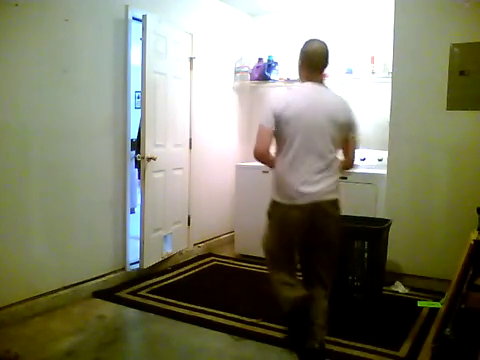

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

img, sg, action = ag_dataset[5]
print(sg)
print(sg.id)
print(sg.node_type)
print(sg.edge_index)
print(sg.edge_attr)

display(img)